In [1]:
!pip install mediapipe opencv-python tensorflow

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.preprocessing import image
from google.colab import files
import math


In [3]:
DATASET_DIR = "/content/drive/MyDrive/final_dataset"   # <--- confirm this path

class_names = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d)) and not d.startswith('.') and not d.lower().endswith('.md')
])

print("✅ Cleaned class count:", len(class_names))
print(class_names)


✅ Cleaned class count: 73
['Alapadmam', 'Alapadmam(1)', 'Anjali', 'Aralam', 'Aralam(1)', 'Ardhachandran', 'Ardhachandran(1)', 'Ardhapathaka', 'Ardhapathaka(1)', 'Berunda', 'Bramaram', 'Bramaram(1)', 'Chakra', 'Chandrakala', 'Chandrakala(1)', 'Chaturam', 'Chaturam(1)', 'Garuda', 'Hamsapaksha', 'Hamsapaksha(1)', 'Hamsasyam', 'Hamsasyam(1)', 'Kangulam', 'Kangulam(1)', 'Kapith', 'Kapith(1)', 'Kapotham', 'Karkatta', 'Kartariswastika', 'Katakamukha', 'Katakavardhana', 'Katrimukha', 'Khatva', 'Kilaka', 'Kurma', 'Matsya', 'Mayura', 'Mayura(1)', 'Mrigasirsha', 'Mrigasirsha(1)', 'Mukulam', 'Mukulam(1)', 'Mushti', 'Mushti(1)', 'Nagabandha', 'Padmakosha', 'Padmakosha(1)', 'Pasha', 'Pathaka', 'Pathaka(1)', 'Pushpaputa', 'Sakata', 'Samputa', 'Sarpasirsha', 'Sarpasirsha(1)', 'Shanka', 'Shivalinga', 'Shukatundam', 'Shukatundam(1)', 'Sikharam', 'Sikharam(1)', 'Simhamukham', 'Simhamukham(1)', 'Suchi', 'Suchi(1)', 'Swastikam', 'Tamarachudam', 'Tamarachudam(1)', 'Tripathaka', 'Tripathaka(1)', 'Trishulam',

In [4]:
mudra_model = tf.keras.models.load_model("/content/drive/MyDrive/mudra_26class.keras")
mudra_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,759,952 (10.53 MB)

 Trainable params: 167,322 (653.60 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 334,646 (1.28 MB)

In [5]:
print("Model output:", mudra_model.output_shape, "Expected:", (None, len(class_names)))


Model output: (None, 26) Expected: (None, 73)


In [7]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)


Saving IMG-20250924-WA0035.jpg to IMG-20250924-WA0035.jpg
✅ Using uploaded image: IMG-20250924-WA0035.jpg


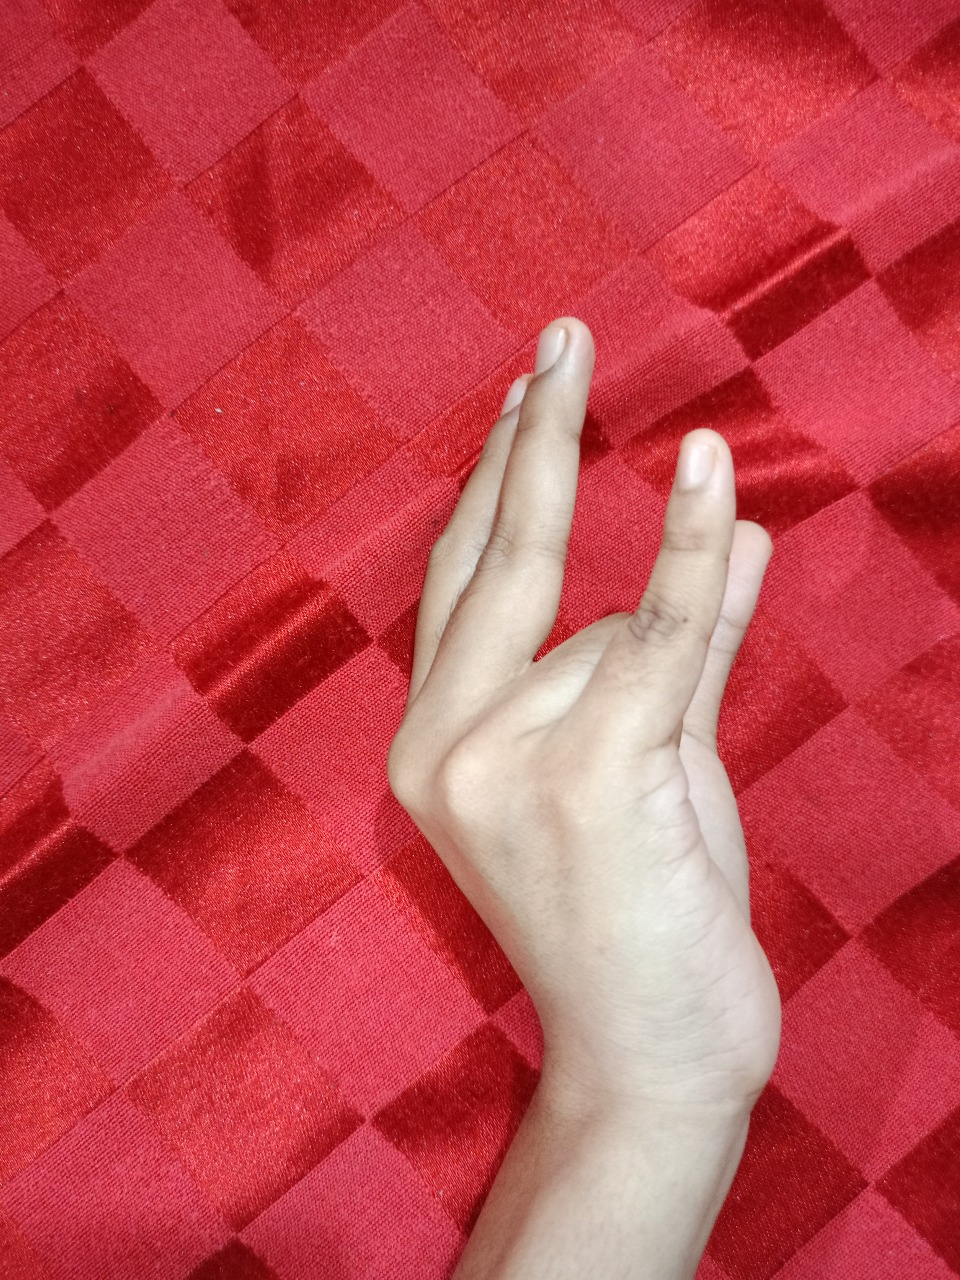

In [8]:
from google.colab import files
from IPython.display import Image as IPImage, display
import cv2

uploaded = files.upload()
for name in uploaded.keys():
    TEST_IMAGE = name
    print("✅ Using uploaded image:", TEST_IMAGE)
    display(IPImage(TEST_IMAGE))


Model preprocessing layer present: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Top predictions (index, prob):
  Aralam(1)                   18.4%
  Bramaram                    16.3%
  Chakra                      16.2%


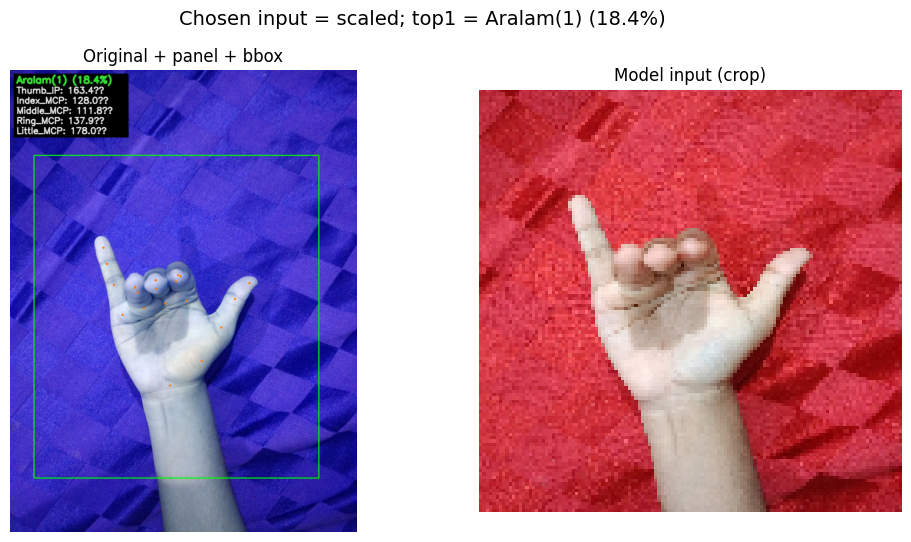

In [19]:
# Robust combined cell: detect -> crop -> predict -> measure angles -> nice overlay
import os, math, numpy as np, cv2, matplotlib.pyplot as plt, mediapipe as mp, tensorflow as tf

# ---------- CONFIG ----------
TEST_IMAGE = "/content/drive/MyDrive/IMG_1.jpg"   # change if needed
IMG_SIZE = (128,128)
TOPK = 3
PAD_FRAC = 0.20   # padding fraction for crop
# -----------------------------

# helper to detect if the model already contains rescaling/preproc
def model_has_preprocessing(model):
    for layer in model.layers[:10]:
        n = layer.name.lower()
        if any(k in n for k in ("rescaling", "normalization", "preprocess")):
            return True
    return False

has_preproc = model_has_preprocessing(mudra_model)
print("Model preprocessing layer present:", has_preproc)

# load image
img_bgr = cv2.imread(TEST_IMAGE)
if img_bgr is None:
    raise FileNotFoundError("Test image not found: " + TEST_IMAGE)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W = img_rgb.shape[:2]

# run mediapipe on full image to locate hand and get landmarks
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
res = hands.process(img_rgb)

if not res.multi_hand_landmarks:
    print("⚠️ No hand detected. The model may fail if fed the whole image.")
    # show original and stop
    plt.figure(figsize=(6,6)); plt.imshow(img_rgb); plt.axis('off'); plt.title("No hand detected"); plt.show()
    hands.close()
else:
    hand_landmarks = res.multi_hand_landmarks[0]

    # compute bbox from landmarks (relative coords)
    xs = [lm.x for lm in hand_landmarks.landmark]
    ys = [lm.y for lm in hand_landmarks.landmark]
    minx, maxx = max(0, min(xs)), min(1, max(xs))
    miny, maxy = max(0, min(ys)), min(1, max(ys))

    # convert to pixel coords and add padding
    x1 = int(max(0, (minx - PAD_FRAC) * W))
    x2 = int(min(W, (maxx + PAD_FRAC) * W))
    y1 = int(max(0, (miny - PAD_FRAC) * H))
    y2 = int(min(H, (maxy + PAD_FRAC) * H))
    if x2<=x1 or y2<=y1:
        x1,y1,x2,y2 = 0,0,W,H

    # crop + resize exactly as model expects
    crop_rgb = img_rgb[y1:y2, x1:x2].copy()
    crop_resized = cv2.resize(crop_rgb, IMG_SIZE)

    # prepare input depending on model preprocessing layer
    if has_preproc:
        model_input = np.expand_dims(crop_resized.astype(np.uint8), axis=0)
    else:
        model_input = np.expand_dims(crop_resized.astype(np.float32) / 255.0, axis=0)

    # predict & show top-K
    pred = mudra_model.predict(model_input)
    probs = pred.flatten()
    idxs = np.argsort(probs)[::-1][:TOPK]
    topk = [(int(i), float(probs[i])) for i in idxs]
    print("Top predictions (index, prob):")
    for i,p in topk:
        lbl = class_names[i] if i < len(class_names) else f"IDX_{i}"
        print(f"  {lbl:25s}  {p*100:5.1f}%")

    top_idx, top_prob = topk[0]
    predicted_label = class_names[top_idx] if top_idx < len(class_names) else f"IDX_{top_idx}"
    conf_pct = top_prob * 100.0

    # compute angles using the *same* landmarks (pixel coords on original image)
    def angle_three(A,B,C):
        BA = (A[0]-B[0], A[1]-B[1])
        BC = (C[0]-B[0], C[1]-B[1])
        dot = BA[0]*BC[0] + BA[1]*BC[1]
        n1 = math.hypot(*BA); n2 = math.hypot(*BC)
        if n1==0 or n2==0: return 0.0
        cosang = max(-1.0, min(1.0, dot/(n1*n2)))
        return math.degrees(math.acos(cosang))

    # joint mapping (use MP standard indices)
    joints = {
        "Thumb_IP": (4,3,2),
        "Index_MCP": (7,6,5),
        "Middle_MCP": (11,10,9),
        "Ring_MCP": (15,14,13),
        "Little_MCP": (19,18,17)
    }
    measured = {}
    for name,(A,B,C) in joints.items():
        lmA = hand_landmarks.landmark[A]; lmB = hand_landmarks.landmark[B]; lmC = hand_landmarks.landmark[C]
        Axy = (int(lmA.x * W), int(lmA.y * H))
        Bxy = (int(lmB.x * W), int(lmB.y * H))
        Cxy = (int(lmC.x * W), int(lmC.y * H))
        measured[name] = round(angle_three(Axy,Bxy,Cxy), 1)

    # ----------------  DRAWING (neat top-left panel) ----------------
    vis = img_rgb.copy()

    # draw bbox on original image so user sees crop
    cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)

    # Panel text lines: first mudra line then angle lines
    panel_lines = [f"{predicted_label} ({conf_pct:.1f}%)"]
    for jn, val in measured.items():
        panel_lines.append(f"{jn}: {val:.1f}°")

    # compute panel size
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.9
    thickness = 2
    pad = 8
    line_height = 28
    max_w = 0
    for line in panel_lines:
        (tw,th),_ = cv2.getTextSize(line, font, font_scale, thickness)
        if tw > max_w: max_w = tw
    panel_w = max_w + pad*2
    panel_h = line_height * len(panel_lines) + pad

    # draw filled semi-opaque rectangle (solid black)
    panel_x, panel_y = 10, 10
    cv2.rectangle(vis, (panel_x, panel_y), (panel_x + panel_w, panel_y + panel_h), (0,0,0), -1)

    # draw each line: mudra in green-ish, angles in white
    for i, line in enumerate(panel_lines):
        y = panel_y + pad + (i+1)*line_height - 10
        if i == 0:
            # mudra line (green)
            cv2.putText(vis, line, (panel_x+pad, y), font, 0.9, (50,220,50), 3, cv2.LINE_AA)
        else:
            # angle lines white
            cv2.putText(vis, line, (panel_x+pad, y), font, 0.8, (230,230,230), 2, cv2.LINE_AA)

    # optional: draw small blue dots for landmarks so user can see
    for lm in hand_landmarks.landmark:
        px, py = int(lm.x*W), int(lm.y*H)
        cv2.circle(vis, (px,py), 3, (0,120,255), -1)

    # show crop on right too (optional)
    crop_show = crop_resized.copy()
    crop_show = cv2.cvtColor(crop_show, cv2.COLOR_RGB2BGR)  # convert for consistent display with cv2->plt
    # display
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); axs[0].axis('off'); axs[0].set_title("Original + panel + bbox")
    axs[1].imshow(crop_resized); axs[1].axis('off'); axs[1].set_title("Model input (crop)")
    plt.suptitle(f"Chosen input = {'raw' if has_preproc else 'scaled'}; top1 = {predicted_label} ({conf_pct:.1f}%)", fontsize=14)
    plt.show()

    hands.close()


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/drive/MyDrive/mudra_dataset"   # <-- use the same folder used in training
datagen = ImageDataGenerator()
train_gen = datagen.flow_from_directory(train_dir, target_size=(128,128))
print(train_gen.class_indices)

# reconstruct correct list in index order
inv = {v:k for k,v in train_gen.class_indices.items()}
class_names = [inv[i] for i in range(len(inv))]
print("✅ Correct class_names:", class_names)


Found 241 images belonging to 26 classes.
{'Alapadmam(1)': 0, 'Aralam(1)': 1, 'Ardhachandran(1)': 2, 'Ardhapathaka(1)': 3, 'Bramaram(1)': 4, 'Chandrakala(1)': 5, 'Chaturam(1)': 6, 'Hamsapaksha(1)': 7, 'Hamsasyam(1)': 8, 'Kangulam(1)': 9, 'Kapith(1)': 10, 'Katakamukha_1': 11, 'Mayura(1)': 12, 'Mrigasirsha(1)': 13, 'Mukulam(1)': 14, 'Mushti(1)': 15, 'Padmakosha(1)': 16, 'Pathaka(1)': 17, 'Sarpasirsha(1)': 18, 'Shukatundam(1)': 19, 'Sikharam(1)': 20, 'Simhamukham(1)': 21, 'Suchi(1)': 22, 'Tamarachudam(1)': 23, 'Tripathaka(1)': 24, 'Trishulam(1)': 25}
✅ Correct class_names: ['Alapadmam(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Bramaram(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Katakamukha_1', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Padmakosha(1)', 'Pathaka(1)', 'Sarpasirsha(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)']


In [25]:
from google.colab import output
from IPython.display import Javascript
from base64 import b64decode

def capture_colab_photo(filename='photo.jpg'):
    js = Javascript('''
    async function takePhoto() {
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Create capture button
      const button = document.createElement('button');
      button.textContent = '📸 Capture';
      document.body.appendChild(button);

      // Wait for click
      await new Promise(resolve => button.onclick = resolve);

      // Take snapshot
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      // Stop stream
      stream.getTracks().forEach(t => t.stop());
      video.remove();
      button.remove();

      // Return base64 image data
      return canvas.toDataURL('image/jpeg', 0.9);
    }
    takePhoto()
    ''')

    # this runs JS in the Colab frontend and returns the data URL string
    data = output.eval_js(js)
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


Model: functional
Model input shape: (None, 128, 128, 3)
Model output shape: (None, 26)

len(class_names) = 26
model_output_dim = 26
first 10 class_names: ['Alapadmam(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Bramaram(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)']
last 10 class_names: ['Padmakosha(1)', 'Pathaka(1)', 'Sarpasirsha(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)']

Loaded test image: /content/drive/MyDrive/IMG_1.jpg shape: (1280, 960, 3)
Crop coords: (18, 172, 902, 1194)  crop shape: (1022, 884, 3)


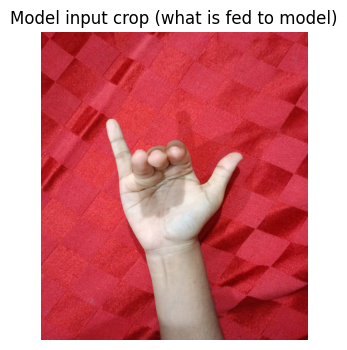


Crop resized shape: (128, 128, 3) dtype: uint8 min/max: 2 254 mean: 112.297607421875

Top-5 for uint8_raw:
  idx  12 prob 0.3484 label: Mayura(1)
  idx  15 prob 0.1643 label: Mushti(1)
  idx  22 prob 0.1068 label: Suchi(1)
  idx  16 prob 0.0677 label: Padmakosha(1)
  idx  19 prob 0.0589 label: Shukatundam(1)

Top-5 for scaled_1:
  idx  10 prob 0.3214 label: Kapith(1)
  idx  13 prob 0.1971 label: Mrigasirsha(1)
  idx  19 prob 0.0787 label: Shukatundam(1)
  idx  12 prob 0.0658 label: Mayura(1)
  idx   4 prob 0.0613 label: Bramaram(1)

Top-5 for scaled_-1_1:
  idx   4 prob 0.2547 label: Bramaram(1)
  idx  19 prob 0.2083 label: Shukatundam(1)
  idx  10 prob 0.1013 label: Kapith(1)
  idx  12 prob 0.0680 label: Mayura(1)
  idx  13 prob 0.0529 label: Mrigasirsha(1)

Top-5 for mobilenet_v3.preprocess_input:
  idx  12 prob 0.3484 label: Mayura(1)
  idx  15 prob 0.1643 label: Mushti(1)
  idx  22 prob 0.1068 label: Suchi(1)
  idx  16 prob 0.0677 label: Padmakosha(1)
  idx  19 prob 0.0589 label: 

In [26]:
# Diagnostic cell: run this after loading mudra_model and class_names
import numpy as np, cv2, math, matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v3
import tensorflow as tf
import os

TEST_IMAGE = "/content/drive/MyDrive/IMG_1.jpg"   # change if another image
IMG_SIZE = (128,128)
TOPK = 5
PAD_FRAC = 0.25

print("Model:", getattr(mudra_model, "name", mudra_model))
print("Model input shape:", mudra_model.input_shape)
print("Model output shape:", mudra_model.output_shape)
model_output_dim = int(mudra_model.output_shape[-1])

# class_names sanity
print("\nlen(class_names) =", len(class_names))
print("model_output_dim =", model_output_dim)
print("first 10 class_names:", class_names[:10])
print("last 10 class_names:", class_names[-10:])

# load image and run mediapipe to compute crop (same crop you use)
try:
    import mediapipe as mp
    mp_hands = mp.solutions.hands
except Exception as e:
    print("mediapipe not available:", e)
    mp_hands = None

img_bgr = cv2.imread(TEST_IMAGE)
if img_bgr is None:
    raise FileNotFoundError("Test image not found at: " + TEST_IMAGE)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H,W = img_rgb.shape[:2]
print("\nLoaded test image:", TEST_IMAGE, "shape:", img_rgb.shape)

# compute crop using mediapipe (same as pipeline)
if mp_hands is not None:
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
    res = hands.process(img_rgb)
else:
    res = None

if res is None or not getattr(res, "multi_hand_landmarks", None):
    print("WARNING: mediapipe did NOT detect a hand. Using full image as crop.")
    x1,y1,x2,y2 = 0,0,W,H
else:
    lm = res.multi_hand_landmarks[0]
    xs = [p.x for p in lm.landmark]; ys = [p.y for p in lm.landmark]
    x1 = int((max(0, min(xs)-PAD_FRAC)) * W)
    y1 = int((max(0, min(ys)-PAD_FRAC)) * H)
    x2 = int((min(1, max(xs)+PAD_FRAC)) * W)
    y2 = int((min(1, max(ys)+PAD_FRAC)) * H)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W, x2), min(H, y2)
    if x2-x1 < 10 or y2-y1 < 10:
        print("WARNING: crop too small or invalid. Using full image instead.")
        x1,y1,x2,y2 = 0,0,W,H

crop = img_rgb[y1:y2, x1:x2]
print("Crop coords:", (x1,y1,x2,y2), " crop shape:", crop.shape)
plt.figure(figsize=(4,4)); plt.imshow(crop); plt.axis('off'); plt.title("Model input crop (what is fed to model)"); plt.show()

# helper: show topk for a prediction array
def show_topk(pred, name, class_list):
    probs = pred.flatten()
    idxs = np.argsort(probs)[::-1][:TOPK]
    print(f"\nTop-{TOPK} for {name}:")
    for i in idxs:
        label = class_list[i] if i < len(class_list) else f"IDX_{i}_no_label"
        print(f"  idx {i:3d} prob {probs[i]:0.4f} label: {label}")

# prepare different preprocessing versions
crop_resized = cv2.resize(crop, IMG_SIZE, interpolation=cv2.INTER_AREA)
print("\nCrop resized shape:", crop_resized.shape, "dtype:", crop_resized.dtype,
      "min/max:", crop_resized.min(), crop_resized.max(), "mean:", crop_resized.mean())

# Candidate inputs:
arr_uint8 = np.expand_dims(crop_resized.astype(np.uint8), 0)             # 0..255 uint8
arr_scaled = np.expand_dims(crop_resized.astype(np.float32)/255.0, 0)    # 0..1
arr_1275 = np.expand_dims(crop_resized.astype(np.float32)/127.5 - 1.0, 0) # -1..1
try:
    # mobilenet_v3 preprocess_input
    fn = mobilenet_v3.preprocess_input
    arr_mbv3 = fn(crop_resized.copy().astype(np.float32))
    arr_mbv3 = np.expand_dims(arr_mbv3, 0)
    have_mbv3 = True
except Exception:
    have_mbv3 = False
    arr_mbv3 = None

# Also try scaled uint8 (if model has internal rescaling)
arr_uint8_float = arr_uint8.astype(np.float32)

# Run predictions and show top-k for each preprocessing mode
candidates = [
    ("uint8_raw", arr_uint8),
    ("scaled_1", arr_scaled),
    ("scaled_-1_1", arr_1275),
]
if have_mbv3:
    candidates.append(("mobilenet_v3.preprocess_input", arr_mbv3))
candidates.append(("uint8_as_float", arr_uint8_float))

for name, arr in candidates:
    try:
        pred = mudra_model.predict(arr, verbose=0)
        show_topk(pred, name, class_names)
        # warn if any predicted index >= class_names
        top_idx = int(np.argmax(pred))
        if top_idx >= len(class_names):
            print("WARNING: predicted index", top_idx, ">= len(class_names) (", len(class_names), ")")
    except Exception as e:
        print("Prediction error for", name, ":", e)

# Show model layers that might be preprocess/rescaling
print("\nFirst 12 layers (name, class):")
for lyr in mudra_model.layers[:12]:
    print(" ", lyr.name, "->", type(lyr).__name__)
# Search for Rescaling/Normalization layers
found = False
for lyr in mudra_model.layers:
    n = type(lyr).__name__.lower()
    if "rescaling" in n or "normalization" in n or "preprocess" in n:
        print("Found preprocessing layer:", lyr.name, type(lyr).__name__)
        found = True
if not found:
    print("No explicit Rescaling/Normalization layer found in the first X layers.")

print("\nDiagnostic finished. Inspect the top-k outputs above to decide which preprocessing to use.")


Model preprocessing layer present: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Top predictions (raw uint8) -> use this if model includes preprocessing layer:
  idx  12  0.3556   Chakra
  idx  15  0.1916   Chaturam
  idx  22  0.1087   Kangulam
  idx  10  0.0796   Bramaram
  idx  16  0.0603   Chaturam(1)

Top predictions (scaled /255) -> use this if model expects normalized inputs:
  idx  10  0.1706   Bramaram
  idx  19  0.1456   Hamsapaksha(1)
  idx  12  0.1431   Chakra
  idx   4  0.1197   Aralam(1)
  idx  15  0.0774   Chaturam

Chosen input: scaled  -> top1: Bramaram (17.1%)
⚠️ low confidence (top1 < 50%). Consider checking crop/preprocessing or showing top-3 instead.


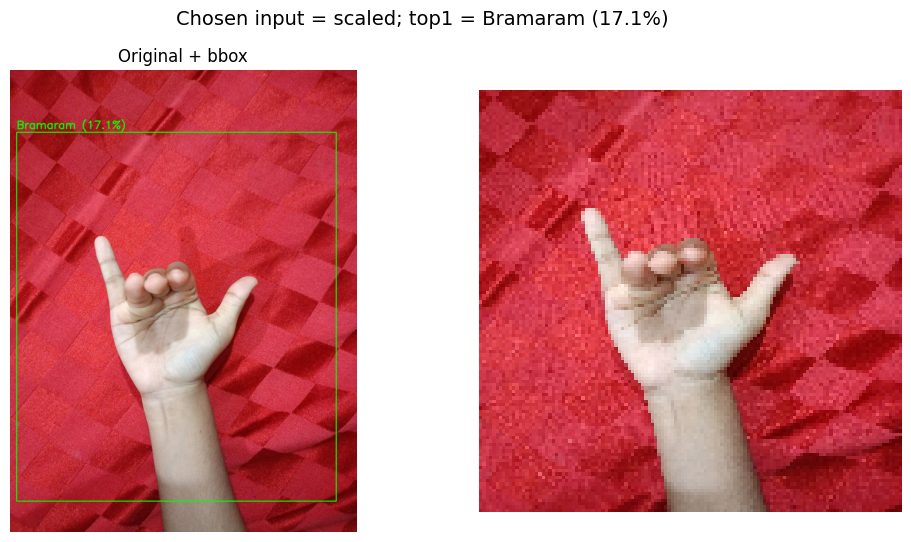

In [20]:
# Paste & run this cell (assumes mudra_model is already loaded)
import cv2, os, math, numpy as np, matplotlib.pyplot as plt, mediapipe as mp
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from pprint import pprint

IMG_SIZE = (128,128)            # same size you trained on
TEST_IMAGE = "/content/drive/MyDrive/IMG_1.jpg"   # change if different
TOPK = 5
PAD_FRAC = 0.25                 # how much padding to add around detected hand bbox (25%)

# --- helper: detect if model has preprocessing (rescaling/normalization) layer ---
def model_has_preprocessing(model):
    for layer in model.layers[:8]:
        name = layer.name.lower()
        if any(k in name for k in ("rescaling","normalization","preprocess")):
            return True
    return False

has_preproc = model_has_preprocessing(mudra_model)
print("Model preprocessing layer present:", has_preproc)

# --- load or compute class_names if not present ---
try:
    class_names  # if already defined in notebook
except NameError:
    DATASET_DIR = "/content/drive/MyDrive/final_dataset"   # change if needed
    class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR,d)) and not d.startswith('.')])
    print("Loaded class_names from DATASET_DIR; count =", len(class_names))

# --- load image ---
img_bgr = cv2.imread(TEST_IMAGE)
if img_bgr is None:
    raise FileNotFoundError("Test image not found at: " + TEST_IMAGE)
h, w = img_bgr.shape[:2]
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# --- detect hand and bbox using MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
res = hands.process(img_rgb)

if not res.multi_hand_landmarks:
    print("⚠️ MediaPipe did NOT detect a hand in the image. The model will likely fail on full-image input.")
    # fallback: use whole image as 'crop'
    x1,y1,x2,y2 = 0,0,w,h
else:
    lm = res.multi_hand_landmarks[0]
    xs = [p.x for p in lm.landmark]; ys = [p.y for p in lm.landmark]
    minx, maxx = max(0, min(xs)), min(1, max(xs))
    miny, maxy = max(0, min(ys)), min(1, max(ys))
    # convert to pixel coords
    x1 = int(max(0, (minx - PAD_FRAC) * w))
    x2 = int(min(w, (maxx + PAD_FRAC) * w))
    y1 = int(max(0, (miny - PAD_FRAC) * h))
    y2 = int(min(h, (maxy + PAD_FRAC) * h))

# make sure box valid
x1,x2 = max(0,x1), max(1,x2)
y1,y2 = max(0,y1), max(1,y2)
if x2 <= x1 or y2 <= y1:
    x1,y1,x2,y2 = 0,0,w,h

crop_rgb = img_rgb[y1:y2, x1:x2]
if crop_rgb.size == 0:
    crop_rgb = img_rgb.copy()

crop_resized = cv2.resize(crop_rgb, IMG_SIZE)

# prepare inputs: raw uint8 and scaled float
arr_uint8 = np.expand_dims(crop_resized.astype(np.uint8), axis=0)
arr_scaled = np.expand_dims(crop_resized.astype(np.float32) / 255.0, axis=0)

def topk(pred, k=TOPK):
    probs = pred.flatten()
    idxs = np.argsort(probs)[::-1][:k]
    return [(int(i), float(probs[i])) for i in idxs]

# run both predictions
pred_raw = mudra_model.predict(arr_uint8)
pred_scaled = mudra_model.predict(arr_scaled)
top_raw = topk(pred_raw, TOPK)
top_scaled = topk(pred_scaled, TOPK)

print("\nTop predictions (raw uint8) -> use this if model includes preprocessing layer:")
for i,p in top_raw:
    name = class_names[i] if i < len(class_names) else f"IDX_{i}"
    print(f"  idx {i:3d}  {p:0.4f}   {name}")

print("\nTop predictions (scaled /255) -> use this if model expects normalized inputs:")
for i,p in top_scaled:
    name = class_names[i] if i < len(class_names) else f"IDX_{i}"
    print(f"  idx {i:3d}  {p:0.4f}   {name}")

# decide which to trust based on has_preproc and confidence
chosen_input = 'raw' if has_preproc else 'scaled'
chosen_pred = top_raw[0] if chosen_input=='raw' else top_scaled[0]
chosen_idx, chosen_prob = chosen_pred
chosen_label = class_names[chosen_idx] if chosen_idx < len(class_names) else f"IDX_{chosen_idx}"

print("\nChosen input:", chosen_input, " -> top1:", chosen_label, f"({chosen_prob*100:.1f}%)")
if chosen_prob < 0.5:
    print("⚠️ low confidence (top1 < 50%). Consider checking crop/preprocessing or showing top-3 instead.")

# --- draw results and show image and crop ---
vis = img_bgr.copy()
cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
txt = f"{chosen_label} ({chosen_prob*100:.1f}%)"
cv2.putText(vis, txt, (x1, max(15, y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2, cv2.LINE_AA)

# show top-5 in a panel
panel = crop_resized.copy()
panel_h = 40 + 30 * TOPK
panel_canvas = np.full((panel_h, panel.shape[1], 3), 30, dtype=np.uint8)
y = 28
for idx,prob in (top_raw if chosen_input=='raw' else top_scaled):
    nm = class_names[idx] if idx < len(class_names) else f"IDX_{idx}"
    text = f"{nm}: {prob*100:.1f}%"
    cv2.putText(panel_canvas, text, (8, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (220,220,220), 2, cv2.LINE_AA)
    y += 30

# display combined
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); axs[0].set_title('Original + bbox'); axs[0].axis('off')
axs[1].imshow(crop_resized); axs[1].axis('off'); axs[1].imshow # show crop
plt.suptitle(f"Chosen input = {chosen_input}; top1 = {chosen_label} ({chosen_prob*100:.1f}%)", fontsize=14)
plt.show()

hands.close()


In [73]:
import mediapipe as mp
import numpy as np
import cv2
import math

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

def calculate_angle(a, b, c):
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) -
        math.atan2(a[1]-b[1], a[0]-b[0])
    )
    return abs(ang) if abs(ang) <= 180 else 360-abs(ang)

def get_finger_angles(landmarks, w, h):
    coords = [(int(lm.x * w), int(lm.y * h)) for lm in landmarks]
    return {
        "Index_PIP": calculate_angle(coords[5], coords[6], coords[7]),
        "Middle_PIP": calculate_angle(coords[9], coords[10], coords[11]),
        "Ring_PIP": calculate_angle(coords[13], coords[14], coords[15]),
        "Little_PIP": calculate_angle(coords[17], coords[18], coords[19])
    }


In [74]:
def predict_mudra_from_image(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_array = np.expand_dims(img_resized / 255.0, axis=0)
    pred = mudra_model.predict(img_array)
    pred_idx = np.argmax(pred)
    label = class_names[pred_idx]
    confidence = float(np.max(pred)) * 100
    print(f"Predicted Mudra: {label} ({confidence:.2f}%)")
    return label, confidence


In [75]:
import numpy as np
mudra_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 4, 4, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 73)             │        18,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,232,004 (19.96 MB)

 Trainable params: 1,590,457 (6.07 MB)

 Non-trainable params: 2,051,088 (7.82 MB)

 Optimizer params: 1,590,459 (6.07 MB)

In [11]:
DATASET_DIR = "/content/drive/MyDrive/mudra_dataset"


In [13]:
import os

DATASET_DIR = "/content/drive/MyDrive/mudra_dataset"  # <-- change

classes = sorted(os.listdir(DATASET_DIR))
print(classes)


['Alapadmam(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Bramaram(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Katakamukha_1', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Padmakosha(1)', 'Pathaka(1)', 'Sarpasirsha(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)']


In [15]:
MUDRA_LABELS = [
    "Alapadmam",     # 0
    "Aralam",        # 1
    "Ardhachandran", # 2
    "Ardhapathaka",  # 3
    "Bramaram",      # 4
    "Chandrakala",   # 5
    "Chaturam",      # 6
    "Hamsapaksha",   # 7
    "Hamsasyam",     # 8
    "Kangulam",      # 9
    "Kapith",        # 10
    "Katakamukha",   # 11
    "Mayura",        # 12
    "Mrigasirsha",   # 13
    "Mukulam",       # 14
    "Mushti",        # 15
    "Padmakosha",    # 16
    "Pathaka",       # 17
    "Sarpasirsha",   # 18
    "Shukatundam",   # 19
    "Sikharam",      # 20
    "Simhamukham",   # 21
    "Suchi",         # 22
    "Tamarachudam",  # 23
    "Tripathaka",    # 24
    "Trishulam"      # 25
]


In [22]:
pred = mudra_model.predict(np.zeros((1,128,128,3)))
print("Model output shape:", pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Model output shape: (1, 73)


In [23]:
import os

DATASET_DIR = "/content/drive/MyDrive/mudra_dataset"  # change this to your actual folder
labels = sorted(os.listdir(DATASET_DIR))
print("Total classes:", len(labels))
print(labels)


Total classes: 26
['Alapadmam(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Bramaram(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Katakamukha_1', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Padmakosha(1)', 'Pathaka(1)', 'Sarpasirsha(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)']


In [24]:
print("Model output layer shape:", mudra_model.output_shape)


Model output layer shape: (None, 73)


In [28]:
MUDRA_LABELS = [
    'Alapadmam(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)',
    'Bramaram(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Hamsapaksha(1)',
    'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Katakamukha_1',
    'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)',
    'Padmakosha(1)', 'Pathaka(1)', 'Sarpasirsha(1)', 'Shukatundam(1)',
    'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Tamarachudam(1)',
    'Tripathaka(1)', 'Trishulam(1)'
]


In [36]:
MUDRA_REFERENCE_ANGLES = {
    'Pataka': {
        'Index_MCP': {
            'Target': 175,
            'Tolerance': 5,
            'A': 7,  # Index Finger PIP (Mid-joint)
            'B': 6,  # Index Finger MCP (Knuckle - Angle Center)
            'C': 5   # Index Finger Base
        }
    },
    'Mushti': {
        'Index_MCP': {
            'Target': 40,
            'Tolerance': 5,
            'A': 7,  # Index Finger PIP (Mid-joint)
            'B': 6,  # Index Finger MCP (Knuckle - Angle Center)
            'C': 5   # Index Finger Base
        }
    },
    'Shikhara': {
        'Thumb_IP': {
            'Target': 175,
            'Tolerance': 5,
            'A': 4,  # Index Finger PIP (Mid-joint)
            'B': 3,  # Index Finger MCP (Knuckle - Angle Center)
            'C': 2   # Index Finger Base
        }
    },
    'Katakamukha': {
        'Index_MCP': {
            'Target': 60,
            'Tolerance': 5,
            'A': 7,  # Index Finger PIP (Mid-joint)
            'B': 6,  # Index Finger MCP (Knuckle - Angle Center)
            'C': 5   # Index Finger Base
        }
    },
    'Ardhachandraa': {
        'Thumb_MCP': {
            'Target': 110,
            'Tolerance': 5,
            'A': 3,  # Index Finger PIP (Mid-joint)
            'B': 2,  # Index Finger MCP (Knuckle - Angle Center)
            'C': 1   # Index Finger Base
        }
    },

}

In [37]:
def calculate_joint_accuracy(measured, target, tolerance=5, max_angle=180):
    """
    Returns accuracy (0–100) based on difference between measured & target.
    Within tolerance = 100%, otherwise scaled.
    """
    diff = abs(measured - target)
    if diff <= tolerance:
        return 100.0
    # outside tolerance → scale accuracy
    excess = diff - tolerance
    accuracy = max(0, 100 - (excess / max_angle) * 100)
    return round(accuracy, 2)


In [40]:
import math
import numpy as np
import cv2

# helper - angle at B formed by points A-B-C (pixel coords)
def angle_between_three_points(A, B, C):
    BAx, BAy = A[0]-B[0], A[1]-B[1]
    BCx, BCy = C[0]-B[0], C[1]-B[1]
    dot = BAx*BCx + BAy*BCy
    normBA = math.hypot(BAx, BAy)
    normBC = math.hypot(BCx, BCy)
    if normBA == 0 or normBC == 0:
        return 0.0
    cosang = max(-1.0, min(1.0, dot/(normBA*normBC)))
    return math.degrees(math.acos(cosang))

# helper - map difference -> accuracy %
def calculate_joint_accuracy(measured, target, tolerance=5, max_angle=180):
    diff = abs(measured - target)
    if diff <= tolerance:
        return 100.0
    excess = diff - tolerance
    acc = max(0.0, 100.0 - (excess / max_angle) * 100.0)
    return round(acc, 2)

# Replace your detect_mudra with this
def detect_mudra(frame):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)             # uses your mediapipe 'hands' object
    if not result.multi_hand_landmarks:
        return frame

    h, w, _ = frame.shape

    for hand_landmarks in result.multi_hand_landmarks:
        # draw landmarks
        mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # bounding box (same logic you had)
        x_coords = [int(lm.x * w) for lm in hand_landmarks.landmark]
        y_coords = [int(lm.y * h) for lm in hand_landmarks.landmark]
        x1, y1, x2, y2 = max(0, min(x_coords)), max(0, min(y_coords)), min(w, max(x_coords)), min(h, max(y_coords))

        # add padding and crop safely
        pad = 20
        x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
        x2p = min(w, x2 + pad); y2p = min(h, y2 + pad)
        hand_img = frame[y1p:y2p, x1p:x2p]

        # --- Prepare image for model ---
        try:
            hand_resized = cv2.resize(hand_img, IMG_SIZE)   # IMG_SIZE must be defined (e.g., (128,128) or (224,224))
        except Exception:
            # fallback: use entire frame if crop failed
            hand_resized = cv2.resize(frame, IMG_SIZE)

        # NOTE: If your base_model used include_preprocessing=True you should NOT divide by 255 here.
        # We pass the uint8 array and let the Keras preprocessing layer handle it.
        hand_array = np.expand_dims(hand_resized, axis=0)

        # --- Predict (this produces probabilities) ---
        pred = mudra_model.predict(hand_array)   # make sure mudra_model is loaded in the notebook
        pred = np.asarray(pred)
        pred_idx = int(np.argmax(pred, axis=-1)[0])
        label = class_names[pred_idx]            # class_names must have been saved from the training step
        confidence = float(np.max(pred)) * 100.0

        predicted_mudra = label   # <--- this avoids NameError; use label directly

        # --- Compute measured angles for joints referenced in MUDRA_REFERENCE_ANGLES ---
        measured_angles = {}
        ref_map = MUDRA_REFERENCE_ANGLES.get(predicted_mudra, {})

        for joint_name, joint_info in ref_map.items():
            A_idx = joint_info.get("A")
            B_idx = joint_info.get("B")
            C_idx = joint_info.get("C")
            if A_idx is None or B_idx is None or C_idx is None:
                continue
            # get pixel coords for the three landmarks
            try:
                lmA = hand_landmarks.landmark[A_idx]
                lmB = hand_landmarks.landmark[B_idx]
                lmC = hand_landmarks.landmark[C_idx]
            except Exception:
                continue
            A_xy = (int(lmA.x * w), int(lmA.y * h))
            B_xy = (int(lmB.x * w), int(lmB.y * h))
            C_xy = (int(lmC.x * w), int(lmC.y * h))
            angle_val = angle_between_three_points(A_xy, B_xy, C_xy)
            measured_angles[joint_name] = angle_val

        # --- Compare measured angles with target and compute per-joint accuracy ---
        accuracies = {}
        for joint_name, joint_info in ref_map.items():
            target = joint_info.get("Target")
            tol = joint_info.get("Tolerance", 5)
            if joint_name in measured_angles and target is not None:
                acc = calculate_joint_accuracy(measured_angles[joint_name], target, tolerance=tol)
                accuracies[joint_name] = acc

        overall_acc = 0.0
        if accuracies:
            overall_acc = sum(accuracies.values()) / len(accuracies)

        # --- Draw results on the frame ---
        # label + confidence
        cv2.putText(frame, f"{predicted_mudra} {confidence:.1f}%", (x1p, max(15, y1p-40)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        # per-joint accuracies (draw below the label)
        ty = max(10, y1p-20)
        for joint, acc in accuracies.items():
            cv2.putText(frame, f"{joint}: {acc:.1f}%", (x1p, ty),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            ty += 18

        # overall
        cv2.putText(frame, f"Overall: {overall_acc:.1f}%", (x1p, ty+2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,200,255), 2)

    return frame


In [41]:
mudra_model.save("/content/drive/MyDrive/mudra_26class.keras")


In [42]:
!find "/content/drive/MyDrive" -maxdepth 3 -type f \( -iname "*.keras" -o -iname "*.h5" \)


/content/drive/MyDrive/mudra_model.keras
/content/drive/MyDrive/mudra_26class.keras


In [57]:
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2, numpy as np, base64


In [58]:
# JavaScript bridge to open webcam and take photo
display(Javascript('''
async function takePhoto(quality=0.8) {
  const div = document.createElement('div');
  const video = document.createElement('video');
  const btn = document.createElement('button');
  btn.textContent = 'Capture';
  div.appendChild(video);
  div.appendChild(btn);
  document.body.appendChild(div);

  const stream = await navigator.mediaDevices.getUserMedia({video: true});
  video.srcObject = stream;
  await video.play();

  // Wait for user to click capture
  await new Promise((resolve) => btn.onclick = resolve);

  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(t => t.stop());
  div.remove();

  return canvas.toDataURL('image/jpeg', quality);
}
'''))


<IPython.core.display.Javascript object>

In [59]:
def capture_from_webcam():
    data = eval_js("takePhoto(0.8)")
    binary = base64.b64decode(data.split(',')[1])
    img_array = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img


In [60]:
def upload_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = cv2.imread(fn)
        return img


In [68]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np
import PIL

# JavaScript code to capture image from webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const video = document.createElement('video');
          div.appendChild(video);
          document.body.appendChild(div);

          // Activate webcam
          const stream = await navigator.mediaDevices.getUserMedia({video: true});
          video.srcObject = stream;
          await video.play();

          // Wait for user to click
          await new Promise((resolve) => {
            const btn = document.createElement('button');
            btn.textContent = 'Capture';
            div.appendChild(btn);
            btn.onclick = () => { resolve(); };
          });

          // Draw frame to canvas
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);

          // Stop video stream
          stream.getTracks().forEach(track => track.stop());
          div.remove();

          return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto({quality: %f});
    ''' % quality)
    display(js)

    data = eval_js("google.colab.kernel.invokeFunction('notebook.takePhoto', [], {})")
    return data

# Bridge for JS → Python
def js_capture():
    data = eval_js("takePhoto(0.8)")
    binary = b64decode(data.split(',')[1])
    img = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    return img

# Run live camera capture
def run_colab_camera():
    print("📸 Click 'Capture' to take a photo")
    img = js_capture()

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            mp_draw.draw_landmarks(img, handLms, mp_hands.HAND_CONNECTIONS)

            h, w, _ = img.shape
            angles = get_finger_angles(handLms.landmark, w, h)

            mudra = predict_mudra(img)

            cv2.putText(img, f"Mudra: {mudra}", (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

            for i, (finger, ang) in enumerate(angles.items()):
                cv2.putText(img, f"{finger}: {int(ang)}", (20, 100+30*i),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    cv2_imshow(img)


In [69]:
print("Choose Mode:")
print("1. Upload an Image")
print("2. Live Camera (works in Colab via JS)")

choice = input("Enter 1 or 2: ")

if choice == "1":
    run_on_uploaded_image()
elif choice == "2":
    run_colab_camera()
else:
    print("❌ Invalid choice")


Choose Mode:
1. Upload an Image
2. Live Camera (works in Colab via JS)
Enter 1 or 2: 1


Saving IMG_1.jpg to IMG_1 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


IndexError: list index out of range